In [40]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import git

import torch as t
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils import tensorboard
from poutyne.framework import Model

from sklearn.metrics import confusion_matrix, recall_score, precision_score


import datetime
import time
from tqdm import tqdm

from pathlib import Path
import os.path

from itertools import product

t.manual_seed(5)
np.random.seed(12)

In [41]:
#Check cuda avilability
t.cuda.device_count()
t.cuda.get_device_name(0)
t.cuda.is_available()

True

In [42]:
#Setting the device

device = t.device("cuda" if t.cuda.is_available() else "cpu")#Uncomment this if you have a GPU that PyTorch supports
# device=t.device("cpu")#UNcomment this if you only have a CPU or a GPU not supported by PyTorch

## Data processing and loading

In [43]:
# #Setting default path
# cd "./home/rahulmoozhikkal/Desktop/ML1/"

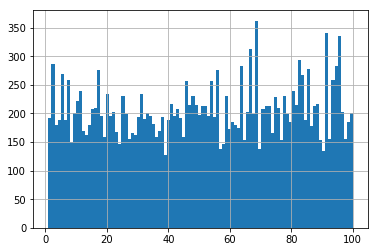

In [44]:
path="./data/pred_maintenance/Turbofan_ Engine_ Degradation/"

#Train data
train_data1=pd.read_csv(f'{path}PM_train.txt',sep=" ", header=None)
train_data1.drop(train_data1.columns[[26,27]],axis=1,inplace=True)

train_data1.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                    's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']

#Create extra column for cycle_norm also for the train data
train_data1['cycle_norm'] = train_data1['cycle']

train_data1["id"].hist(bins=100)
# train_data1["id"].value_counts().sort_index()
RUL_train_data1=pd.DataFrame(train_data1.groupby("id")["cycle"].max()).reset_index()
RUL_train_data1.columns=["id","max_cycle"]
train_data1=train_data1.merge(RUL_train_data1,how="left",on=["id"])
train_data1["RUL"]=train_data1["max_cycle"]-train_data1["cycle"]
train_data1.drop(columns="max_cycle",inplace=True)

,0
0,112
1,98
2,69
3,82
4,91


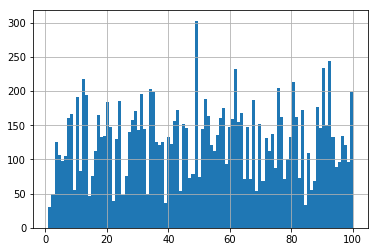

In [45]:

#Test data
test_data1=pd.read_csv(f'{path}PM_test.txt',sep=" ",header=None)
truth_df=pd.read_csv(f'{path}PM_truth.txt',sep=" ", header=None)

test_data1.drop(labels=[26,27],axis=1,inplace=True)
test_data1.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                    's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']

test_data1["id"].hist(bins=100)

truth_df.drop(labels=1,axis=1,inplace=True)
truth_df.head()

In [46]:
#Labeling train data
w1=30
w0=15


train_data1["label1"]=np.where(train_data1["RUL"]<=w1,1,0)
train_data1["label2"]=train_data1["label1"]
train_data1.loc[train_data1["RUL"] <= w0,"label2"]=2

#Defining the data for easy reference for future callback
train_data_pre=train_data1.copy()
test_data_pre=test_data1.copy()
truth_pre_df=truth_df.copy()

In [47]:
#Define the training mode
# train_mod="class"

#Options
#1."Class"
#2."reg"


#Define the label (the column name in which you want to train)

#Options are 

#Classification        #Regression

#1-"label1"             "RUL"
#2-"label2"

# y_label="label1"

In [48]:
str1="RUL "


if str1=="RUL":
    print(True)

In [49]:
def data_process(train_data,test_data,truth_df,y_label):
    

    train_data1=train_data
    test_data1=test_data
    truth_df=truth_df


    #Normalise the data
    # MinMax normalization
    norm_cols=train_data1.columns.difference(["id","cycle","label1","label2"])


    if y_label == "RUL":

        #RUL normalisation for regression
        RUL_scal=preprocessing.MinMaxScaler()
        RUL_scal.fit(train_data1[["RUL","RUL","RUL"]])
 
        
    else:
        
        RUL_scal=None
    
    #Min-max scaling
    min_max_scaler=preprocessing.MinMaxScaler()
    norm_train_data1=pd.DataFrame(min_max_scaler.fit_transform(train_data1[norm_cols]),columns=norm_cols,index=train_data1.index)
    temp_df=norm_train_data1.join(train_data1[train_data1.columns.difference(norm_cols)])
    train_data1=temp_df.reindex(columns=train_data1.columns)
    train_data1.head(5)

    test_data1['cycle_norm'] = test_data1['cycle']

    # Generate column max for test data
    rul = pd.DataFrame(test_data1.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']

    truth_df.columns = ['more']
    truth_df['id'] = truth_df.index + 1
    truth_df['max'] = rul['max'] + truth_df['more']
    truth_df.drop('more', axis=1, inplace=True)

    #Calculate RUL for test data
    test_data1=test_data1.merge(truth_df,how="left",on="id")
    test_data1["RUL"]=test_data1["max"]-test_data1["cycle"]
    test_data1.drop("max",axis=1,inplace=True)

    #Labeling for test data
    test_data1["label1"]=np.where(test_data1["RUL"]<=w1,1,0)
    test_data1["label2"]=test_data1["label1"]
    test_data1.loc[test_data1["RUL"]<=w0,"label2"]=2

    norm_test_data1=pd.DataFrame(min_max_scaler.transform(test_data1[norm_cols]),columns=norm_cols,index=test_data1.index)
    temp_df=norm_test_data1.join(test_data1[test_data1.columns.difference(norm_cols)])
    test_data1=temp_df.reindex(columns=test_data1.columns)


    return train_data1,test_data1,RUL_scal

In [50]:
#Define inputs needed for generating the sequence
#This is needed to make the input in the form of (sequence_length,batch, input_size)


def gen_sequence(train_data,test_data,y_label,seq_len):
    
    train_data1=train_data
    test_data1=test_data
    
    #Defining the columns to be used for training
    sen_cols=["s"+str(i) for i in range(1,22)]
    seq_cols=['setting1', 'setting2', 'setting3', 'cycle_norm']
    seq_cols.extend(sen_cols)

    #Generate sequences
    def gen_seq(id_df,seq_len,seq_cols):
        data_arr=id_df[seq_cols].values
        num_elem=data_arr.shape[0]

        for start,stop in zip(range(0,num_elem-seq_len),range(seq_len,num_elem)):
            yield data_arr[start:stop,:]
            
    #Generate labels
    def gen_labels(id_df,seq_len,seq_lab):

        data_arr=id_df[seq_lab].values
        num_elem=data_arr.shape[0]

        return data_arr[seq_len:num_elem,:]

    #Sequence generator for better memory handling
    train_seq_gen=(list(gen_seq(train_data1[train_data1["id"]==id],seq_len,seq_cols)) for id in train_data1["id"].unique())
    # test_seq_gen=(list(gen_seq(test_data1[test_data1["id"]==id],seq_len,seq_cols)) for id in test_id_in)

    #Convert sequence to numpy array for use in PyTorch
    train_seq_arr=np.concatenate(list(train_seq_gen)).astype(np.float32)
    
    
    seq_lab=[y_label]
    train_lab_gen=[gen_labels(train_data1[train_data1["id"]==id],seq_len,seq_lab) for id in train_data1["id"].unique()]
    train_lab_arr=np.concatenate(list(train_lab_gen)).astype(np.float32)
    
    
    #Test data sequence preparation
    
    #Remove IDs from test data which have less than 50 in a particular id

    test_id=pd.pivot_table(test_data1,index=["id"],aggfunc={"id":np.count_nonzero})
    test_id.columns=["count"]
    test_id=test_id[test_id["count"]>=seq_len]
    test_id_in=test_id.index
       
    #Make input array
    seq_array_test_last=[test_data1[test_data1["id"]==id][seq_cols].values[-seq_len:] for id in test_id_in]
    seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)


    #Make test array labels
    test_last_lab_gen=[test_data1[test_data1["id"]==id][seq_lab].values[-1] for id in test_id_in]
    test_last_lab_arr=np.asarray(test_last_lab_gen).astype(np.float32)
    
    return train_seq_arr,train_lab_arr,seq_array_test_last,test_last_lab_arr

In [51]:
#Define dataloader
class PredMaintDataset(Dataset):
    
    def __init__(self,data_arr,lab_arr,seq_len):
        
        self.len=len(lab_arr)
        self.iter=0
        
        #Conversion to tensors from numpy arrays
        self.x_data=t.from_numpy(data_arr).to(device)
        
        self.label=t.from_numpy(lab_arr).to(device)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self,index):
        return self.x_data[index,:,:],self.label[index]

In [52]:
#Defining test,valid and training data for dataloader

def dataloader(train_data_pre,test_data_pre,truth_df,ylabel,seq_len,train_batch_size,val_split):
    
    def train_valid_split(inp_data,val_split,axis=0): 
        train_len=np.int(np.floor(inp_data.shape[axis]-np.floor(val_split*inp_data.shape[axis])))
        train_data,valid_data=inp_data[0:train_len],inp_data[train_len:]
        return train_data,valid_data
    
    train_data, test_data,RUL_scal=data_process(train_data_pre,test_data_pre,truth_df,ylabel)
    train_seq_arr,train_lab_arr,seq_array_test_last,test_last_lab_arr=gen_sequence(train_data, test_data,ylabel,seq_len)
    
    x_train,x_valid=train_valid_split(train_seq_arr,val_split)
    y_train,y_valid=train_valid_split(train_lab_arr,val_split)
#     print(f"x_train_shape={x_train.shape[0]}")

    train_pred_dataset=PredMaintDataset(x_train,y_train,seq_len=seq_len)
    train_loader=DataLoader(dataset=train_pred_dataset,batch_size=train_batch_size)

    valid_pred_dataset=PredMaintDataset(x_valid,y_valid,seq_len=seq_len)
    valid_loader=DataLoader(dataset=valid_pred_dataset,batch_size=y_valid.shape[0])

    test_pred_dataset=PredMaintDataset(seq_array_test_last,test_last_lab_arr,seq_len=seq_len)
    test_loader=DataLoader(dataset=test_pred_dataset,batch_size=test_last_lab_arr.shape[0])  
    
    return train_loader,valid_loader, test_loader,RUL_scal

In [53]:
# train_batch_size=200

#Uncomment below code section if you want to use full data for training ()

train_batch_size=200
# train_batch_size=14850 #if you want to use all the data (for 0.05 valid split)

val_split=0.05
seq_len=50

train_class_loader,valid_class_loader,test_class_loader,RUL_scal=dataloader(train_data_pre,test_data_pre,truth_df.copy(),"label1",seq_len,train_batch_size,val_split)

train_reg_loader,valid_reg_loader,test_reg_loader,RUL_scal=dataloader(train_data_pre,test_data_pre,truth_df.copy(),"RUL",seq_len,train_batch_size,val_split)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Modelling

### LSTM module Implementation

In [54]:
model_set=False

if model_set:
    
    #Modelling an LSTM

    input_size_l1=25#seq_arr.shape[2]
    hidden_size_l1=100

    input_size_l2=100#hidden_size_l1
    hidden_size_l2=50

    #Hidden size list
    hid_siz_list=[hidden_size_l1,hidden_size_l2]

    output_size=test_last_lab_arr.shape[1]

    num_layers=3
    

    class PredLSTM(nn.Module):
        def __init__(self,inp_size,hid_siz_list,out_siz,num_layers,seq_len):
            super().__init__()     

            self.inp_size=inp_size
            self.hid_siz_list=hid_siz_list
            self.out_siz=out_siz
            self.num_layers=num_layers
            self.seq_len=seq_len


            self.lstm1=nn.LSTM(self.inp_size,self.hid_siz_list[0])
    #                 self.NN_layers.append(nn.Dropout(p=0.2))

            self.lstm2=nn.LSTM(self.hid_siz_list[0],self.hid_siz_list[1])
    #                 self.NN_layers.append(nn.Dropout(p=0.2))

            self.lin=nn.Linear(self.hid_siz_list[1],self.out_siz)

            self.drp=nn.Dropout(0.2)

            self.sigm=nn.Sigmoid()



        def forward(self,x):

            hn1,(h1,_)=self.lstm1(x.view(self.seq_len,-1,self.inp_size))
    #         h1.detach_()
    #         c1.detach_()

            hn1=self.drp(hn1)

            _,(h2,_)=self.lstm2(hn1)
    #         h2.detach_()
    #         c2.detach_()  

            h2=self.drp(h2)

            out=self.lin(h2)

            out=self.sigm(out)

            return out

In [55]:
train_set=False
if train_set:

    model_LSTMmod=PredLSTM(inp_size=input_size_l1,hid_siz_list=hid_siz_list,out_siz=1,num_layers=3,seq_len=seq_len)

### LSTM Cell implementation

In [56]:
#Modelling an LSTM using LSTMCell

class PredLSTMCell(nn.Module):
    
    def __init__(self,inp_size,hid_siz_list,out_siz,num_layers,seq_len,drp_lay, type_out):
        super().__init__()     
        
        #Model parameters
        self.inp_size=inp_size
        self.hid_siz_list=hid_siz_list
        self.out_siz=out_siz
        self.num_layers=num_layers
        self.seq_len=seq_len
        self.typ_out=type_out
        
        #Model architecture
        self.lstm1=nn.LSTMCell(self.inp_size,self.hid_siz_list[0])

        self.lstm2=nn.LSTMCell(self.hid_siz_list[0],self.hid_siz_list[1])
        
        self.lin=nn.Linear(self.hid_siz_list[1],self.out_siz)
        
        self.drp1=nn.Dropout(drp_lay[0])
        self.drp2=nn.Dropout(drp_lay[1])
        
        self.class_act=nn.Sigmoid()
        
        self.reg_act=nn.ReLU()
        
        self.init_model()
    
    def init_model(self):
        
        for name, param in self.named_parameters():
    #         print(f"Name of layer={name},parameter={param}")
            if "bias" in name:
                nn.init.constant_(param,0)
#                 print(f"Name of layer={name},Bias (constant init),Weight of layer={param}")
            
            elif any (x in name for x in ["weight_ih","lin"]):
                nn.init.xavier_uniform_(param)
#                 print(f"Name of layer={name},Weight_ih(Xavier init),Weight of layer={param}")
                    
            elif f"weight_hh" in f"{name}":
                nn.init.orthogonal_(param)
#                 print(f"Name of layer={name},Weight_hh(Orthogonal init,Weight of layer={param}")
        
        print(f"Input Weights initialised as per Xavier uniform and Hidden weights as per orthogonal")  
        print(f"Biases initialised to zero")
        
    def forward(self,x):
        
        h1 = t.zeros(x.size(0), self.hid_siz_list[0]).to(device)
        c1 = t.zeros(x.size(0), self.hid_siz_list[0]).to(device)
        h2 = t.zeros(x.size(0), self.hid_siz_list[1]).to(device)
        c2 = t.zeros(x.size(0), self.hid_siz_list[1]).to(device)
    
        for i,inp_t in enumerate(x.chunk(x.size(1),dim=1)):
            h1,c1=self.lstm1(inp_t.view(-1,self.inp_size),(h1,c1))
            
            if i!=x.size(1)-1:
                h2,c2=self.lstm2(h1,(h2,c2))
            else:
                h2,c2=self.lstm2(self.drp1(h1),(h2,c2))
            
        h2=self.drp2(h2)
        
        out=self.lin(h2)
        
        if self.typ_out=="class":
            out=self.class_act(out)
        elif self.typ_out=="reg":
            out=self.reg_act(out)
            
        return out

## Training

#### General function and basic log settings

In [57]:
#Metric

def class_metric_calc(data_loader,model,print_out):
    
    model.eval()
    
    x_inputs,y=next(iter(data_loader))
    y_pred=model.forward(x_inputs)
    
    #Compute and print loss
    
    loss_calc=criterion(y_pred.view(-1,1),y)
    

    TP=t.mul(y_pred.round().reshape(-1)==1,y.reshape(-1)==1).sum()
    TN=t.mul(y_pred.round().reshape(-1)==0,y.reshape(-1)==0).sum()
    
    NP=y[y==1].shape[0]
    NN=y[y==0].shape[0]
                
        
    acc=100*t.eq(y_pred.round(),y).sum()/y.shape[0]
    
    if (TP+NN-TN)!=0:
        prec=100*TP/(TP+NN-TN)
    else:
        prec=0
    
    if NP!=0:
        rec=100*TP/NP
    else:
        rec=0
        
    if NN!=0:
        spec=100*TN/NN
    else:
        spec=0
        
    if print_out:
        
        print(f"\nNumber of positives in the label={NP}, Predicted as positive and is actually positive={TP}\
            \nNumber of negatives in the label={NN}, Predicted as negative and is actually negative={TN}")
        
        
        
        print(f"loss={loss_calc.item()}\
                \n\nAccuracy(fraction of pos and neg predicted correctly)={acc:.2f}%\
                \nRecall(fraction of pos predicted correctly)={rec:.2f}% \
                \nPrecision(fraction of TP in all predicted as positives)={prec:.2f}%\
                \nSpecificity(fraction of neg predicted correctly)={spec:.2f}%")

    return acc,rec,prec,spec,loss_calc

In [58]:
# class_metric_calc(valid_class_loader,model_LSTMcell_class,True)

In [59]:
#Metric

def reg_metric_calc(data_loader,model,RUL_scal,df_out,loss_out):
    
    model.eval()
    
    x_inputs,y=next(iter(data_loader))
#     print(f"x={x_inputs}")
    y_pred=model.forward(x_inputs)
    loss_calc=criterion(y_pred.view(-1,1),y)
                           
    if df_out:
        
        #Outputs
        np_y_pred=y_pred.reshape(-1).data.numpy()
        np_y=y.reshape(-1).data.numpy()

        abs_val_diff=np.abs(np_y_pred-np_y)
        per_val_diff=100*abs_val_diff/np_y       
        
        reg_df=pd.DataFrame({"Predicted_RUL":np_y_pred,"True_RUL":np_y,\
                             "Absolute_val_diff":abs_val_diff,"Percentage_val_diff":per_val_diff},index=np.arange(len(y)))

        scal_df_data=RUL_scal.inverse_transform(reg_df[["Predicted_RUL","True_RUL","Absolute_val_diff"]])
        scal_df=pd.DataFrame(scal_df_data,columns=["Predicted_RUL","True_RUL","Absolute_val_diff"])


        reg_df.drop(labels=["Predicted_RUL","True_RUL","Absolute_val_diff"],axis=1,inplace=True)
        out=scal_df.join(reg_df,how="left")
    
    elif loss_out:
        
        out=loss_calc.item()
    
    return out

### Train-LSTM Module 

In [60]:
def mod_train_func(model,train_loader,valid_loader,num_epochs,stop_train):
    glob_iter=0
    for epoch in range(num_epochs):
        

        for i,data in enumerate(train_loader):

            x_inputs,y=data

            glob_iter+=1
            
            y_pred=model.forward(x_inputs.view(seq_len,-1,input_size_l1))

            loss=criterion(y_pred.view(-1,1),y)
            
            optimizer.zero_grad()       
            loss.backward()
            optimizer.step() 
            
        if i%50==0 or i==len(train_loader)-2:
            print("\n*****************Train data metrics************************\n")
            print(f"Epoch={epoch}/{num_epochs}")
            metric_calc(train_loader,model)
            print("\n*****************Valid data metrics************************\n")
            print(f"Epoch={epoch}/{num_epochs}")
            val_acc,val_rec,val_prec,val_spec,_,_= metric_calc(valid_loader,model)

In [61]:
#Training
train_set=0

if train_set:
   
    num_epochs=50
    criterion=nn.BCELoss()
    optimizer = t.optim.Adam(params=model_LSTMmod.parameters())
    stop_train=[95, 95, 95]
    
    mod_train_func(model_LSTMmod,train_loader,valid_loader,num_epochs,stop_train)

### Train-LSTM Cell 

#### Classification

In [62]:
#Add cuda support for tensors

def class_cell_train_func(model,loss_fun,optimizer,lear_rate,num_epochs,train_loader,valid_loader,stop_train,log_set):

    
    #Defining the logging 
    
    if log_set:
    
        log_dir_base=f"./Logs/Tensorboard/"
        act_fin=str(model.class_act).replace("()","")
        t_pre=datetime.datetime.now().strftime("%d-%b-%y_%H:%M:%S")
        inst_name=f'{t_pre}_class_{model.__class__.__name__}_LSTM1_{model.hid_siz_list[0]}_DRP1_{model.drp1.__dict__["p"]}_LSTM2_{model.hid_siz_list[1]}_DRP2_{str(model.drp2.__dict__["p"])}_LIN_ACT_{str(model.class_act).replace("()","")}_lr_{lear_rate}_seq_ln_{model.seq_len}_stp_acc_rec_{stop_train[0]}_{stop_train[1]}'
        
        log_dir_class=f"{log_dir_base}{inst_name}"
        
        writer=SummaryWriter(log_dir_class)
    
    for epoch in range(num_epochs):
        
        t_start=datetime.datetime.now()
        print(f'\nStarting Epoch={epoch}/{num_epochs} @ {t_start.strftime("%d-%b-%y_%H:%M:%S")}')
        
        train_loss=t.tensor(0,dtype=t.float32).to(device)
        met_bunch=t.tensor([0,0,0,0],dtype=t.float32).to(device)
        
        glob_cnt=0
        
        for i,data in enumerate(train_loader):
            
            model.train()
            
            optimizer.zero_grad()
            x_inputs,y=data

            y_pred_train=model.forward(x_inputs)
            loss=loss_fun(y_pred_train.view(-1,1),y)

            loss.backward()
            optimizer.step()            

            
            train_it_acc,train_it_rec,train_it_prec,train_it_spec,_=class_metric_calc(train_loader,model,False)
            met_it_bunch=t.tensor([train_it_acc,train_it_rec,train_it_prec,train_it_spec],dtype=t.float32).to(device)
            
            num_items=y.shape[0]
            
            train_loss+=loss.data

            met_bunch=((glob_cnt*met_bunch)+ met_it_bunch*num_items)/(glob_cnt+num_items)
                       
            glob_cnt+=num_items
                    
        t_fin=datetime.datetime.now()
        t_diff=(t_fin-t_start)
        print(f'Finished epoch={epoch}/{num_epochs}@ {t_fin.strftime("%d-%b-%y_%H:%M:%S")}')
        print(f'Epoch run time = {t_diff.seconds}s')
        
        print("\n*****************Train data metrics************************\n")

        print(f"Epoch loss={train_loss:.6f}\
            \n\nAccuracy(fraction of pos and neg predicted correctly)={met_bunch[0]:.2f}%\
            \nRecall(fraction of pos predicted correctly)={met_bunch[1]:.2f}% \
            \nPrecision(fraction of TP in all predicted as positives)={met_bunch[2]:.2f}%\
            \nSpecificity(fraction of neg predicted correctly)={met_bunch[3]:.2f}%")
        
        
        print("\n*****************Valid data metrics************************\n")
        val_acc,val_rec,val_prec,val_spec,val_loss=class_metric_calc(valid_loader,model,True)

        #Logging for Tensorboard
        if log_set:
            
            writer.add_scalar(tag="Train Loss",scalar_value=train_loss,global_step=epoch)
            writer.add_scalar(tag="Train Accuracy",scalar_value=met_bunch[0],global_step=epoch)
            writer.add_scalar(tag="Train Recall",scalar_value=met_bunch[1],global_step=epoch)
            writer.add_scalar(tag="Train Precision",scalar_value=met_bunch[2],global_step=epoch)
            writer.add_scalar(tag="Train Specificity",scalar_value=met_bunch[3],global_step=epoch)

            writer.add_scalar(tag="Valid Loss",scalar_value=val_loss.item(),global_step=epoch)
            writer.add_scalar(tag="Valid Accuracy",scalar_value=val_acc,global_step=epoch)
            writer.add_scalar(tag="Valid Recall",scalar_value=val_rec,global_step=epoch)
            writer.add_scalar(tag="Valid Precision",scalar_value=val_prec,global_step=epoch)
            writer.add_scalar(tag="Valid Specificity",scalar_value=val_spec,global_step=epoch)      

        if val_acc> stop_train[0] and val_rec > stop_train[1]:
            return 

In [63]:
#Defining model space for experimentation

parameters_class=dict(
    seq_len_class=[50,25, 100, 200],
    
    lear_rate=[1e-3,1e-2,1e-1],
    num_epochs=[15,25],
    
    input_size_l1=[25],
    hidden_size_l1=[25,50,100],
    hidden_size_l2=[25,50,100],
    output_size=[1],
    drop_lay0=[0.1,0.2],
    drop_lay1=[0.1,0.2],
    )


In [64]:
#Defining list of models to be created
ref_fil_df=pd.DataFrame(columns=["File_ID","Parameter_tuple"])
cnt=1

for (seq_len_class,lear_rate,num_epochs,input_size_l1,hidden_size_l1,hidden_size_l2,output_size,drop_lay0,drop_lay1) in product(*param_class_val):
    ref_fil_df=ref_fil_df.append({"File_ID":cnt,"Parameter_tuple":(seq_len_class,lear_rate,num_epochs,input_size_l1,hidden_size_l1,hidden_size_l2,output_size,drop_lay0,drop_lay1)},ignore_index=True)
    cnt+=1
    
ref_fil_df

,File_ID,Parameter_tuple
0,1,"(25, 0.001, 15, 25, 25, 25, 1, 0.1, 0.1)"
1,2,"(25, 0.001, 15, 25, 25, 25, 1, 0.1, 0.2)"
2,3,"(25, 0.001, 15, 25, 25, 25, 1, 0.1, 0.6)"
3,4,"(25, 0.001, 15, 25, 25, 25, 1, 0.2, 0.1)"
4,5,"(25, 0.001, 15, 25, 25, 25, 1, 0.2, 0.2)"
5,6,"(25, 0.001, 15, 25, 25, 25, 1, 0.2, 0.6)"
6,7,"(25, 0.001, 15, 25, 25, 25, 1, 0.6, 0.1)"
7,8,"(25, 0.001, 15, 25, 25, 25, 1, 0.6, 0.2)"
8,9,"(25, 0.001, 15, 25, 25, 25, 1, 0.6, 0.6)"
9,10,"(25, 0.001, 15, 25, 25, 50, 1, 0.1, 0.1)"


In [65]:
#Classification training and logging

train_set=False
log_set=False

start_in=True #Indicator for checking if this code is being run again
cnt=1#For File ID numbers

#Checking if log file list exists 
path_class_mod_filname_df="./Logs/runs_filename/class_mod_filenames"

#Initialisation for log file list
total_list_df=ref_fil_df.copy()

if train_set:
    #File names to be added only if logging is True
    if log_set:

        if not os.path.isfile(path_class_mod_filname_df):

            class_mod_filname_df=pd.DataFrame(columns=["File_ID","Parameter_tuple","Completion Status"])
            total_list_df=ref_fil_df.copy()

        else:
            class_mod_filname_df=pd.read_pickle("./Logs/runs_filename/mod_filenames")
            cnt=len(class_mod_filname_df)+1
            total_list_df=ref_fil_df[ref_fil_df["File_ID"]>=cnt].copy()

    for (seq_len_class,lear_rate,num_epochs,input_size_l1,hidden_size_l1,hidden_size_l2,output_size,drop_lay0,drop_lay1) in total_list_df["Parameter_tuple"]:

        #Model parameters
        drp_lay=[drop_lay0,drop_lay1]
        hid_siz_list=[hidden_size_l1,hidden_size_l2]

        #Defining model and setting to correct device
        model_LSTMcell_class=PredLSTMCell(inp_size=input_size_l1,hid_siz_list=hid_siz_list,out_siz=output_size,num_layers=3,seq_len=seq_len_class,drp_lay=drp_lay,type_out="class")
        model_LSTMcell_class.to(device)

        #Parameters used for training
        optim_class = t.optim.Adam(params=model_LSTMcell_class.parameters(),lr=lear_rate)
        criterion=nn.BCELoss(reduction="mean")

    #     print(f"               (seq_len_class,lear_rate,num_epochs,input_size_l1,hidden_size_l1,hidden_size_l2,output_size,drop_lay0,drop_lay1) ")
        print(f"Training model={(seq_len_class,lear_rate,num_epochs,input_size_l1,hidden_size_l1,hidden_size_l2,output_size,drop_lay0,drop_lay1)}")
    #     print(seq_len_class,lear_rate,num_epochs,input_size_l1,hidden_size_l1,hidden_size_l2,output_size,drop_lay0,drop_lay1)

        stop_train=[95, 95, 95]

        #Calling training
        class_cell_train_func(model_LSTMcell_class,criterion,optim_class,lear_rate,num_epochs,train_class_loader,valid_class_loader,stop_train,log_set)

        if log_set:

            if start_in:
                print(f"Appending log file names from file ID ={cnt}\n")
                start_in=False  

            class_mod_filname_df=class_mod_filname_df.append({"File_ID":cnt,"Parameter_tuple":(seq_len_class,lear_rate,num_epochs,input_size_l1,hidden_size_l1,hidden_size_l2,output_size,drop_lay0,drop_lay1),"Completion Status":True},ignore_index=True)
            class_mod_filname_df.to_pickle("./Logs/runs_filename/mod_filenames")
            cnt+=1



In [66]:
#Uncomment this to control the test file (it has first 3600 model name list)

# test_mod_filname_df.to_pickle("./Logs/runs_filename/test_mod_filenames")
# test_mod_filname_df=pd.read_pickle("./Logs/runs_filename/test_mod_filenames")

In [67]:
#Training
# train_set=True
# log_set=False

# if train_set:
       
#     for seq_len_class,lear_rate,num_epochs,input_size_l1,hidden_size_l1,hidden_size_l2,output_size,drop_lay0,drop_lay1 in product(*param_class_val):

#         #Model parameters
#         drp_lay=[drop_lay0,drop_lay1]
#         hid_siz_list=[hidden_size_l1,hidden_size_l2]
        
#         #Defining model
#         model_LSTMcell_class=PredLSTMCell(inp_size=input_size_l1,hid_siz_list=hid_siz_list,out_siz=output_size,num_layers=3,seq_len=seq_len_class,drp_lay=drp_lay,type_out="class")

#         #Parameters used for training
#         optim_class = t.optim.Adam(params=model_LSTMcell_class.parameters(),lr=lear_rate)
#         criterion=nn.BCELoss(reduction="mean")

#         print(seq_len_class,lear_rate,num_epochs,input_size_l1,hidden_size_l1,hidden_size_l2,output_size,drop_lay0,drop_lay1)
        
#         stop_train=[95, 95, 95]

#         #Calling training
#         class_cell_train_func(model_LSTMcell_class,criterion,optim_class,lear_rate,num_epochs,train_class_loader,valid_class_loader,stop_train,log_set)

#### Regression

In [68]:
#Regression train_func

def reg_cell_train_func(model,loss_fun,optimizer,num_epochs,train_loader,valid_loader,log_set):
    
          
    if log_set:
        
        log_dir_base=f"./Logs/Tensorboard/"
        act_fin=str(model.reg_act).replace("()","")
        t_pre=datetime.datetime.now().strftime("%d-%b-%y_%H:%M:%S")
        inst_name=f'{t_pre}_reg_{model.__class__.__name__}_LSTM1_{model.hid_siz_list[0]}_DRP1_{model.drp1.__dict__["p"]}_LSTM2_{model.hid_siz_list[1]}_DRP2_{str(model.drp2.__dict__["p"])}_LIN_ACT_{str(model.reg_act).replace("()","")}_lr_{lear_rate}_seq_ln_{model.seq_len}'

        log_dir_reg=f"{log_dir_base}{inst_name}"

        writer=SummaryWriter(log_dir_reg)

    for epoch in range(num_epochs):
        
        t_start=datetime.datetime.now()
        print("\n***********************************************************\n")
        print(f'\nStarting Epoch={epoch}/{num_epochs} @ {t_start.strftime("%d-%b-%y_%H:%M:%S")}')
              
        train_loss=t.tensor(0,dtype=t.float32).to(device)      
        for i,data in enumerate(train_loader):
            
            model.train()

            optimizer.zero_grad()
            x_inputs,y=data
           
            y_pred_train=model.forward(x_inputs)
            loss=loss_fun(y_pred_train.view(-1,1),y)

            loss.backward()
            optimizer.step()   
              
            train_loss+=loss.data

        t_fin=datetime.datetime.now()
        t_diff=(t_fin-t_start)
        
        val_loss=reg_metric_calc(valid_loader,model,RUL_scal,df_out=False,loss_out=True)
        
        if log_set:

            writer.add_scalar(tag="Train Loss",scalar_value=train_loss,global_step=epoch)
            writer.add_scalar(tag="Valid Loss",scalar_value=val_loss,global_step=epoch)
              
        print(f'Finished epoch={epoch}/{num_epochs}@ {t_fin.strftime("%d-%b-%y_%H:%M:%S")}')
        print(f'Epoch run time = {t_diff.seconds}s')
        print("\n*****************Train data metrics************************\n")
        print(f"Epoch loss={train_loss:.6f}")
        print("\n*****************Valid data metrics************************\n")
        print(f"Epoch loss={val_loss:.6f}")      

In [70]:
#Regression training and logging

train_set=True
log_set=True

start_in=True #Indicator for checking if this code is being run again
cnt=1#For File ID numbers

#Checking if log file list exists 
path_reg_mod_filname_df="./Logs/runs_filename/reg_mod_filenames"

#Initialisation for log file list
total_list_df=ref_fil_df.copy()

if train_set:
    #File names to be added only if logging is True
    if log_set:

        if not os.path.isfile(path_reg_mod_filname_df):

            reg_mod_filname_df=pd.DataFrame(columns=["File_ID","Parameter_tuple","Completion Status"])
            total_list_df=ref_fil_df.copy()

        else:
            reg_mod_filname_df=pd.read_pickle("./Logs/runs_filename/reg_mod_filenames")
            cnt=len(reg_mod_filname_df)+1
            total_list_df=ref_fil_df[ref_fil_df["File_ID"]>=cnt].copy()

    for (seq_len_reg,lear_rate,num_epochs,input_size_l1,hidden_size_l1,hidden_size_l2,output_size,drop_lay0,drop_lay1) in total_list_df["Parameter_tuple"]:

        #Model parameters
        drp_lay=[drop_lay0,drop_lay1]
        hid_siz_list=[hidden_size_l1,hidden_size_l2]

        #Defining model and setting to correct device
        model_LSTMcell_reg=PredLSTMCell(inp_size=input_size_l1,hid_siz_list=hid_siz_list,out_siz=output_size,num_layers=3,seq_len=seq_len_reg,drp_lay=drp_lay,type_out="reg")
        model_LSTMcell_reg.to(device)

        #Parameters used for training
        optim_reg = t.optim.Adam(params=model_LSTMcell_reg.parameters(),lr=lear_rate)
        criterion=nn.BCELoss(reduction="mean")

        print(f"Training model={(seq_len_reg,lear_rate,num_epochs,input_size_l1,hidden_size_l1,hidden_size_l2,output_size,drop_lay0,drop_lay1)}")

        #Calling training
        reg_cell_train_func(model_LSTMcell_reg,criterion,optim_reg,num_epochs,train_reg_loader,valid_reg_loader,log_set)

        if log_set:

            if start_in:
                print(f"Appending log file names from file ID ={cnt}\n")
                start_in=False  

            reg_mod_filname_df=reg_mod_filname_df.append({"File_ID":cnt,"Parameter_tuple":(seq_len_reg,lear_rate,num_epochs,input_size_l1,hidden_size_l1,hidden_size_l2,output_size,drop_lay0,drop_lay1),"Completion Status":True},ignore_index=True)
            reg_mod_filname_df.to_pickle("./Logs/runs_filename/reg_mod_filenames")
            cnt+=1
 


Input Weights initialised as per Xavier uniform and Hidden weights as per orthogonal
Biases initialised to zero
Training model=(25, 0.001, 15, 25, 25, 100, 1, 0.2, 0.2)

***********************************************************


Starting Epoch=0/15 @ 05-Aug-19_23:23:47
Finished epoch=0/15@ 05-Aug-19_23:23:51
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=43.798141

*****************Valid data metrics************************

Epoch loss=0.523378

***********************************************************


Starting Epoch=1/15 @ 05-Aug-19_23:23:51
Finished epoch=1/15@ 05-Aug-19_23:23:55
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.461792

*****************Valid data metrics************************

Epoch loss=0.507429

***********************************************************


Starting Epoch=2/15 @ 05-Aug-19_23:23:55
Finished epoch=2/15@ 05-Aug-19_23:24:00
Epoch run time = 4s

********

Finished epoch=9/15@ 05-Aug-19_23:25:32
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=37.936214

*****************Valid data metrics************************

Epoch loss=0.504254

***********************************************************


Starting Epoch=10/15 @ 05-Aug-19_23:25:32
Finished epoch=10/15@ 05-Aug-19_23:25:36
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=37.873959

*****************Valid data metrics************************

Epoch loss=0.503099

***********************************************************


Starting Epoch=11/15 @ 05-Aug-19_23:25:36
Finished epoch=11/15@ 05-Aug-19_23:25:40
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=37.816185

*****************Valid data metrics************************

Epoch loss=0.503038

***********************************************************


Starting Epoch=12/15 @ 05-Aug-19_23:25:40
Finished

Finished epoch=3/15@ 05-Aug-19_23:27:16
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.039036

*****************Valid data metrics************************

Epoch loss=0.509645

***********************************************************


Starting Epoch=4/15 @ 05-Aug-19_23:27:16
Finished epoch=4/15@ 05-Aug-19_23:27:20
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.041153

*****************Valid data metrics************************

Epoch loss=0.504016

***********************************************************


Starting Epoch=5/15 @ 05-Aug-19_23:27:20
Finished epoch=5/15@ 05-Aug-19_23:27:24
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.305279

*****************Valid data metrics************************

Epoch loss=0.508115

***********************************************************


Starting Epoch=6/15 @ 05-Aug-19_23:27:24
Finished epoc

Finished epoch=13/15@ 05-Aug-19_23:29:04
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=37.913815

*****************Valid data metrics************************

Epoch loss=0.506939

***********************************************************


Starting Epoch=14/15 @ 05-Aug-19_23:29:04
Finished epoch=14/15@ 05-Aug-19_23:29:09
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=37.995232

*****************Valid data metrics************************

Epoch loss=0.503437
Input Weights initialised as per Xavier uniform and Hidden weights as per orthogonal
Biases initialised to zero
Training model=(25, 0.001, 15, 25, 25, 200, 1, 0.1, 0.1)

***********************************************************


Starting Epoch=0/15 @ 05-Aug-19_23:29:09
Finished epoch=0/15@ 05-Aug-19_23:29:14
Epoch run time = 5s

*****************Train data metrics************************

Epoch loss=42.602955

*****************Valid dat

Finished epoch=7/15@ 05-Aug-19_23:31:11
Epoch run time = 5s

*****************Train data metrics************************

Epoch loss=37.785503

*****************Valid data metrics************************

Epoch loss=0.504287

***********************************************************


Starting Epoch=8/15 @ 05-Aug-19_23:31:11
Finished epoch=8/15@ 05-Aug-19_23:31:16
Epoch run time = 5s

*****************Train data metrics************************

Epoch loss=37.632713

*****************Valid data metrics************************

Epoch loss=0.503618

***********************************************************


Starting Epoch=9/15 @ 05-Aug-19_23:31:16
Finished epoch=9/15@ 05-Aug-19_23:31:22
Epoch run time = 5s

*****************Train data metrics************************

Epoch loss=37.727791

*****************Valid data metrics************************

Epoch loss=0.503026

***********************************************************


Starting Epoch=10/15 @ 05-Aug-19_23:31:22
Finished epo

Finished epoch=1/15@ 05-Aug-19_23:33:08
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.552792

*****************Valid data metrics************************

Epoch loss=0.508321

***********************************************************


Starting Epoch=2/15 @ 05-Aug-19_23:33:08
Finished epoch=2/15@ 05-Aug-19_23:33:13
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.347340

*****************Valid data metrics************************

Epoch loss=0.508554

***********************************************************


Starting Epoch=3/15 @ 05-Aug-19_23:33:13
Finished epoch=3/15@ 05-Aug-19_23:33:17
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.218288

*****************Valid data metrics************************

Epoch loss=0.509283

***********************************************************


Starting Epoch=4/15 @ 05-Aug-19_23:33:17
Finished epoc

Finished epoch=11/15@ 05-Aug-19_23:35:05
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.198631

*****************Valid data metrics************************

Epoch loss=0.509082

***********************************************************


Starting Epoch=12/15 @ 05-Aug-19_23:35:05
Finished epoch=12/15@ 05-Aug-19_23:35:09
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=37.671227

*****************Valid data metrics************************

Epoch loss=0.505150

***********************************************************


Starting Epoch=13/15 @ 05-Aug-19_23:35:09
Finished epoch=13/15@ 05-Aug-19_23:35:14
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=37.623955

*****************Valid data metrics************************

Epoch loss=0.503627

***********************************************************


Starting Epoch=14/15 @ 05-Aug-19_23:35:14
Finishe

Finished epoch=5/15@ 05-Aug-19_23:36:57
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.065403

*****************Valid data metrics************************

Epoch loss=0.505215

***********************************************************


Starting Epoch=6/15 @ 05-Aug-19_23:36:57
Finished epoch=6/15@ 05-Aug-19_23:37:02
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=37.924541

*****************Valid data metrics************************

Epoch loss=0.504628

***********************************************************


Starting Epoch=7/15 @ 05-Aug-19_23:37:02
Finished epoch=7/15@ 05-Aug-19_23:37:06
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=37.868366

*****************Valid data metrics************************

Epoch loss=0.504076

***********************************************************


Starting Epoch=8/15 @ 05-Aug-19_23:37:06
Finished epoc

Finished epoch=0/15@ 05-Aug-19_23:38:54
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=46.264275

*****************Valid data metrics************************

Epoch loss=0.530807

***********************************************************


Starting Epoch=1/15 @ 05-Aug-19_23:38:54
Finished epoch=1/15@ 05-Aug-19_23:38:59
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.945206

*****************Valid data metrics************************

Epoch loss=0.523172

***********************************************************


Starting Epoch=2/15 @ 05-Aug-19_23:38:59
Finished epoch=2/15@ 05-Aug-19_23:39:03
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.808094

*****************Valid data metrics************************

Epoch loss=0.509786

***********************************************************


Starting Epoch=3/15 @ 05-Aug-19_23:39:03
Finished epoc

Finished epoch=10/15@ 05-Aug-19_23:40:39
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=37.833652

*****************Valid data metrics************************

Epoch loss=0.506093

***********************************************************


Starting Epoch=11/15 @ 05-Aug-19_23:40:39
Finished epoch=11/15@ 05-Aug-19_23:40:43
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=37.983906

*****************Valid data metrics************************

Epoch loss=0.504721

***********************************************************


Starting Epoch=12/15 @ 05-Aug-19_23:40:43
Finished epoch=12/15@ 05-Aug-19_23:40:46
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=37.691196

*****************Valid data metrics************************

Epoch loss=0.505988

***********************************************************


Starting Epoch=13/15 @ 05-Aug-19_23:40:46
Finishe

Finished epoch=4/15@ 05-Aug-19_23:42:06
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=39.132359

*****************Valid data metrics************************

Epoch loss=0.504508

***********************************************************


Starting Epoch=5/15 @ 05-Aug-19_23:42:06
Finished epoch=5/15@ 05-Aug-19_23:42:10
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.595428

*****************Valid data metrics************************

Epoch loss=0.504357

***********************************************************


Starting Epoch=6/15 @ 05-Aug-19_23:42:10
Finished epoch=6/15@ 05-Aug-19_23:42:14
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.407932

*****************Valid data metrics************************

Epoch loss=0.502694

***********************************************************


Starting Epoch=7/15 @ 05-Aug-19_23:42:14
Finished epoc

Finished epoch=14/15@ 05-Aug-19_23:43:38
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.143414

*****************Valid data metrics************************

Epoch loss=0.511304
Input Weights initialised as per Xavier uniform and Hidden weights as per orthogonal
Biases initialised to zero
Training model=(25, 0.001, 15, 25, 50, 25, 1, 0.2, 0.2)

***********************************************************


Starting Epoch=0/15 @ 05-Aug-19_23:43:38
Finished epoch=0/15@ 05-Aug-19_23:43:42
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=47.439095

*****************Valid data metrics************************

Epoch loss=0.517956

***********************************************************


Starting Epoch=1/15 @ 05-Aug-19_23:43:42
Finished epoch=1/15@ 05-Aug-19_23:43:45
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.736698

*****************Valid data m

Finished epoch=8/15@ 05-Aug-19_23:45:06
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.322212

*****************Valid data metrics************************

Epoch loss=0.509847

***********************************************************


Starting Epoch=9/15 @ 05-Aug-19_23:45:06
Finished epoch=9/15@ 05-Aug-19_23:45:10
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.693027

*****************Valid data metrics************************

Epoch loss=0.500390

***********************************************************


Starting Epoch=10/15 @ 05-Aug-19_23:45:10
Finished epoch=10/15@ 05-Aug-19_23:45:13
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.292931

*****************Valid data metrics************************

Epoch loss=0.500257

***********************************************************


Starting Epoch=11/15 @ 05-Aug-19_23:45:13
Finished e

Finished epoch=2/15@ 05-Aug-19_23:46:34
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.840981

*****************Valid data metrics************************

Epoch loss=0.510326

***********************************************************


Starting Epoch=3/15 @ 05-Aug-19_23:46:34
Finished epoch=3/15@ 05-Aug-19_23:46:37
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.548046

*****************Valid data metrics************************

Epoch loss=0.511172

***********************************************************


Starting Epoch=4/15 @ 05-Aug-19_23:46:37
Finished epoch=4/15@ 05-Aug-19_23:46:41
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.367416

*****************Valid data metrics************************

Epoch loss=0.503180

***********************************************************


Starting Epoch=5/15 @ 05-Aug-19_23:46:41
Finished epoc

Finished epoch=12/15@ 05-Aug-19_23:48:05
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.670135

*****************Valid data metrics************************

Epoch loss=0.507213

***********************************************************


Starting Epoch=13/15 @ 05-Aug-19_23:48:05
Finished epoch=13/15@ 05-Aug-19_23:48:08
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.570850

*****************Valid data metrics************************

Epoch loss=0.501425

***********************************************************


Starting Epoch=14/15 @ 05-Aug-19_23:48:08
Finished epoch=14/15@ 05-Aug-19_23:48:12
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.271839

*****************Valid data metrics************************

Epoch loss=0.504976
Input Weights initialised as per Xavier uniform and Hidden weights as per orthogonal
Biases initialised to zero


Finished epoch=6/15@ 05-Aug-19_23:49:36
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.280910

*****************Valid data metrics************************

Epoch loss=0.517817

***********************************************************


Starting Epoch=7/15 @ 05-Aug-19_23:49:36
Finished epoch=7/15@ 05-Aug-19_23:49:39
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.235851

*****************Valid data metrics************************

Epoch loss=0.509603

***********************************************************


Starting Epoch=8/15 @ 05-Aug-19_23:49:39
Finished epoch=8/15@ 05-Aug-19_23:49:43
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.062016

*****************Valid data metrics************************

Epoch loss=0.507684

***********************************************************


Starting Epoch=9/15 @ 05-Aug-19_23:49:43
Finished epoc

Finished epoch=0/15@ 05-Aug-19_23:51:07
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=46.648026

*****************Valid data metrics************************

Epoch loss=0.522987

***********************************************************


Starting Epoch=1/15 @ 05-Aug-19_23:51:07
Finished epoch=1/15@ 05-Aug-19_23:51:11
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.959068

*****************Valid data metrics************************

Epoch loss=0.507002

***********************************************************


Starting Epoch=2/15 @ 05-Aug-19_23:51:11
Finished epoch=2/15@ 05-Aug-19_23:51:14
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.846973

*****************Valid data metrics************************

Epoch loss=0.507477

***********************************************************


Starting Epoch=3/15 @ 05-Aug-19_23:51:14
Finished epoc

Finished epoch=10/15@ 05-Aug-19_23:52:44
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.071617

*****************Valid data metrics************************

Epoch loss=0.509064

***********************************************************


Starting Epoch=11/15 @ 05-Aug-19_23:52:44
Finished epoch=11/15@ 05-Aug-19_23:52:48
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.051472

*****************Valid data metrics************************

Epoch loss=0.509234

***********************************************************


Starting Epoch=12/15 @ 05-Aug-19_23:52:48
Finished epoch=12/15@ 05-Aug-19_23:52:52
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=37.911259

*****************Valid data metrics************************

Epoch loss=0.508742

***********************************************************


Starting Epoch=13/15 @ 05-Aug-19_23:52:52
Finishe

Finished epoch=4/15@ 05-Aug-19_23:54:18
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=39.994797

*****************Valid data metrics************************

Epoch loss=0.514256

***********************************************************


Starting Epoch=5/15 @ 05-Aug-19_23:54:18
Finished epoch=5/15@ 05-Aug-19_23:54:21
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=41.405533

*****************Valid data metrics************************

Epoch loss=0.531192

***********************************************************


Starting Epoch=6/15 @ 05-Aug-19_23:54:22
Finished epoch=6/15@ 05-Aug-19_23:54:25
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=39.866379

*****************Valid data metrics************************

Epoch loss=0.520211

***********************************************************


Starting Epoch=7/15 @ 05-Aug-19_23:54:25
Finished epoc

Finished epoch=14/15@ 05-Aug-19_23:55:55
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.624424

*****************Valid data metrics************************

Epoch loss=0.503856
Input Weights initialised as per Xavier uniform and Hidden weights as per orthogonal
Biases initialised to zero
Training model=(25, 0.001, 15, 25, 50, 50, 1, 0.6, 0.6)

***********************************************************


Starting Epoch=0/15 @ 05-Aug-19_23:55:55
Finished epoch=0/15@ 05-Aug-19_23:55:59
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=49.363194

*****************Valid data metrics************************

Epoch loss=0.506382

***********************************************************


Starting Epoch=1/15 @ 05-Aug-19_23:55:59
Finished epoch=1/15@ 05-Aug-19_23:56:03
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=40.427971

*****************Valid data m

Finished epoch=8/15@ 05-Aug-19_23:57:31
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=37.857807

*****************Valid data metrics************************

Epoch loss=0.505325

***********************************************************


Starting Epoch=9/15 @ 05-Aug-19_23:57:31
Finished epoch=9/15@ 05-Aug-19_23:57:35
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=37.726124

*****************Valid data metrics************************

Epoch loss=0.505803

***********************************************************


Starting Epoch=10/15 @ 05-Aug-19_23:57:35
Finished epoch=10/15@ 05-Aug-19_23:57:39
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.363331

*****************Valid data metrics************************

Epoch loss=0.506443

***********************************************************


Starting Epoch=11/15 @ 05-Aug-19_23:57:39
Finished e

Finished epoch=2/15@ 05-Aug-19_23:59:10
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=39.068295

*****************Valid data metrics************************

Epoch loss=0.507626

***********************************************************


Starting Epoch=3/15 @ 05-Aug-19_23:59:10
Finished epoch=3/15@ 05-Aug-19_23:59:14
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.701431

*****************Valid data metrics************************

Epoch loss=0.506854

***********************************************************


Starting Epoch=4/15 @ 05-Aug-19_23:59:14
Finished epoch=4/15@ 05-Aug-19_23:59:19
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.473885

*****************Valid data metrics************************

Epoch loss=0.506616

***********************************************************


Starting Epoch=5/15 @ 05-Aug-19_23:59:19
Finished epoc

Finished epoch=12/15@ 06-Aug-19_00:00:54
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=37.777847

*****************Valid data metrics************************

Epoch loss=0.502533

***********************************************************


Starting Epoch=13/15 @ 06-Aug-19_00:00:54
Finished epoch=13/15@ 06-Aug-19_00:00:58
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=37.686901

*****************Valid data metrics************************

Epoch loss=0.502737

***********************************************************


Starting Epoch=14/15 @ 06-Aug-19_00:00:58
Finished epoch=14/15@ 06-Aug-19_00:01:02
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=39.383053

*****************Valid data metrics************************

Epoch loss=0.533604
Input Weights initialised as per Xavier uniform and Hidden weights as per orthogonal
Biases initialised to zero


Finished epoch=6/15@ 06-Aug-19_00:02:31
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=40.053745

*****************Valid data metrics************************

Epoch loss=0.511445

***********************************************************


Starting Epoch=7/15 @ 06-Aug-19_00:02:31
Finished epoch=7/15@ 06-Aug-19_00:02:35
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=39.334991

*****************Valid data metrics************************

Epoch loss=0.511113

***********************************************************


Starting Epoch=8/15 @ 06-Aug-19_00:02:35
Finished epoch=8/15@ 06-Aug-19_00:02:39
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.961658

*****************Valid data metrics************************

Epoch loss=0.508062

***********************************************************


Starting Epoch=9/15 @ 06-Aug-19_00:02:39
Finished epoc

Finished epoch=0/15@ 06-Aug-19_00:04:07
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=41.504749

*****************Valid data metrics************************

Epoch loss=0.519301

***********************************************************


Starting Epoch=1/15 @ 06-Aug-19_00:04:07
Finished epoch=1/15@ 06-Aug-19_00:04:11
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=39.068836

*****************Valid data metrics************************

Epoch loss=0.518730

***********************************************************


Starting Epoch=2/15 @ 06-Aug-19_00:04:11
Finished epoch=2/15@ 06-Aug-19_00:04:15
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.484882

*****************Valid data metrics************************

Epoch loss=0.545784

***********************************************************


Starting Epoch=3/15 @ 06-Aug-19_00:04:15
Finished epoc

Finished epoch=10/15@ 06-Aug-19_00:05:48
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.428467

*****************Valid data metrics************************

Epoch loss=0.503796

***********************************************************


Starting Epoch=11/15 @ 06-Aug-19_00:05:48
Finished epoch=11/15@ 06-Aug-19_00:05:52
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.314514

*****************Valid data metrics************************

Epoch loss=0.504920

***********************************************************


Starting Epoch=12/15 @ 06-Aug-19_00:05:52
Finished epoch=12/15@ 06-Aug-19_00:05:56
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=39.271435

*****************Valid data metrics************************

Epoch loss=0.510099

***********************************************************


Starting Epoch=13/15 @ 06-Aug-19_00:05:56
Finishe

Finished epoch=4/15@ 06-Aug-19_00:07:42
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.003307

*****************Valid data metrics************************

Epoch loss=0.509387

***********************************************************


Starting Epoch=5/15 @ 06-Aug-19_00:07:42
Finished epoch=5/15@ 06-Aug-19_00:07:47
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.143200

*****************Valid data metrics************************

Epoch loss=0.506662

***********************************************************


Starting Epoch=6/15 @ 06-Aug-19_00:07:47
Finished epoch=6/15@ 06-Aug-19_00:07:52
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=37.988598

*****************Valid data metrics************************

Epoch loss=0.504048

***********************************************************


Starting Epoch=7/15 @ 06-Aug-19_00:07:52
Finished epoc

Finished epoch=14/15@ 06-Aug-19_00:09:45
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=37.799820

*****************Valid data metrics************************

Epoch loss=0.505874
Input Weights initialised as per Xavier uniform and Hidden weights as per orthogonal
Biases initialised to zero
Training model=(25, 0.001, 15, 25, 50, 200, 1, 0.2, 0.1)

***********************************************************


Starting Epoch=0/15 @ 06-Aug-19_00:09:45
Finished epoch=0/15@ 06-Aug-19_00:09:50
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=40.343300

*****************Valid data metrics************************

Epoch loss=0.526938

***********************************************************


Starting Epoch=1/15 @ 06-Aug-19_00:09:50
Finished epoch=1/15@ 06-Aug-19_00:09:55
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.638943

*****************Valid data 

Finished epoch=8/15@ 06-Aug-19_00:11:44
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.101765

*****************Valid data metrics************************

Epoch loss=0.524321

***********************************************************


Starting Epoch=9/15 @ 06-Aug-19_00:11:44
Finished epoch=9/15@ 06-Aug-19_00:11:49
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.088734

*****************Valid data metrics************************

Epoch loss=0.507007

***********************************************************


Starting Epoch=10/15 @ 06-Aug-19_00:11:49
Finished epoch=10/15@ 06-Aug-19_00:11:54
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=37.802948

*****************Valid data metrics************************

Epoch loss=0.505911

***********************************************************


Starting Epoch=11/15 @ 06-Aug-19_00:11:54
Finished e

Finished epoch=2/15@ 06-Aug-19_00:13:44
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=39.015953

*****************Valid data metrics************************

Epoch loss=0.507995

***********************************************************


Starting Epoch=3/15 @ 06-Aug-19_00:13:45
Finished epoch=3/15@ 06-Aug-19_00:13:49
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.381420

*****************Valid data metrics************************

Epoch loss=0.504699

***********************************************************


Starting Epoch=4/15 @ 06-Aug-19_00:13:50
Finished epoch=4/15@ 06-Aug-19_00:13:54
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.120934

*****************Valid data metrics************************

Epoch loss=0.507080

***********************************************************


Starting Epoch=5/15 @ 06-Aug-19_00:13:55
Finished epoc

Finished epoch=12/15@ 06-Aug-19_00:15:50
Epoch run time = 5s

*****************Train data metrics************************

Epoch loss=38.065128

*****************Valid data metrics************************

Epoch loss=0.505034

***********************************************************


Starting Epoch=13/15 @ 06-Aug-19_00:15:50
Finished epoch=13/15@ 06-Aug-19_00:15:55
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=37.823925

*****************Valid data metrics************************

Epoch loss=0.502376

***********************************************************


Starting Epoch=14/15 @ 06-Aug-19_00:15:55
Finished epoch=14/15@ 06-Aug-19_00:16:00
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=37.683792

*****************Valid data metrics************************

Epoch loss=0.501587
Input Weights initialised as per Xavier uniform and Hidden weights as per orthogonal
Biases initialised to zero


Finished epoch=6/15@ 06-Aug-19_00:17:42
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=38.014080

*****************Valid data metrics************************

Epoch loss=0.505971

***********************************************************


Starting Epoch=7/15 @ 06-Aug-19_00:17:42
Finished epoch=7/15@ 06-Aug-19_00:17:46
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=37.927128

*****************Valid data metrics************************

Epoch loss=0.506253

***********************************************************


Starting Epoch=8/15 @ 06-Aug-19_00:17:46
Finished epoch=8/15@ 06-Aug-19_00:17:50
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=37.943077

*****************Valid data metrics************************

Epoch loss=0.506202

***********************************************************


Starting Epoch=9/15 @ 06-Aug-19_00:17:50
Finished epoc

Finished epoch=0/15@ 06-Aug-19_00:19:16
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=49.448181

*****************Valid data metrics************************

Epoch loss=0.529507

***********************************************************


Starting Epoch=1/15 @ 06-Aug-19_00:19:16
Finished epoch=1/15@ 06-Aug-19_00:19:20
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=40.052166

*****************Valid data metrics************************

Epoch loss=0.505196

***********************************************************


Starting Epoch=2/15 @ 06-Aug-19_00:19:20
Finished epoch=2/15@ 06-Aug-19_00:19:24
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=39.321617

*****************Valid data metrics************************

Epoch loss=0.504598

***********************************************************


Starting Epoch=3/15 @ 06-Aug-19_00:19:24
Finished epoc

Finished epoch=10/15@ 06-Aug-19_00:20:53
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=37.734768

*****************Valid data metrics************************

Epoch loss=0.503680

***********************************************************


Starting Epoch=11/15 @ 06-Aug-19_00:20:53
Finished epoch=11/15@ 06-Aug-19_00:20:57
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=37.703228

*****************Valid data metrics************************

Epoch loss=0.503163

***********************************************************


Starting Epoch=12/15 @ 06-Aug-19_00:20:57
Finished epoch=12/15@ 06-Aug-19_00:21:01
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=37.717121

*****************Valid data metrics************************

Epoch loss=0.503832

***********************************************************


Starting Epoch=13/15 @ 06-Aug-19_00:21:01
Finishe

Finished epoch=4/15@ 06-Aug-19_00:22:29
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=40.110077

*****************Valid data metrics************************

Epoch loss=0.507971

***********************************************************


Starting Epoch=5/15 @ 06-Aug-19_00:22:29
Finished epoch=5/15@ 06-Aug-19_00:22:33
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=39.509487

*****************Valid data metrics************************

Epoch loss=0.501531

***********************************************************


Starting Epoch=6/15 @ 06-Aug-19_00:22:33
Finished epoch=6/15@ 06-Aug-19_00:22:37
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.703739

*****************Valid data metrics************************

Epoch loss=0.506758

***********************************************************


Starting Epoch=7/15 @ 06-Aug-19_00:22:37
Finished epoc

Finished epoch=14/15@ 06-Aug-19_00:24:10
Epoch run time = 3s

*****************Train data metrics************************

Epoch loss=37.669495

*****************Valid data metrics************************

Epoch loss=0.503911
Input Weights initialised as per Xavier uniform and Hidden weights as per orthogonal
Biases initialised to zero
Training model=(25, 0.001, 15, 25, 100, 25, 1, 0.6, 0.2)

***********************************************************


Starting Epoch=0/15 @ 06-Aug-19_00:24:10
Finished epoch=0/15@ 06-Aug-19_00:24:14
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=39.691380

*****************Valid data metrics************************

Epoch loss=0.518404

***********************************************************


Starting Epoch=1/15 @ 06-Aug-19_00:24:14
Finished epoch=1/15@ 06-Aug-19_00:24:18
Epoch run time = 4s

*****************Train data metrics************************

Epoch loss=38.965446

*****************Valid data 

RuntimeError: reduce failed to synchronize: device-side assert triggered

## Metrics and validation

#### Classification

In [ ]:
!tensorboard --logdir "{log_dir_base}"

In [ ]:
# x_inputs,y=next(iter(test_loader))
# yp_pred=model_LSTMcell_class.forward(x_inputs)
# print(f"x_input shape={x_inputs.shape}")
# print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
# cm = confusion_matrix(y.detach().numpy(), yp_pred.detach().numpy().round())
# precision = precision_score(y.detach().numpy(), yp_pred.detach().numpy().round())
# recall = recall_score(y.detach().numpy(), yp_pred.detach().numpy().round())

# print( 'precision = ', precision, '\n', 'recall = ', recall)
# cm
# # type(y.detach().numpy())
# # type(yp_pred.detach().numpy())

In [ ]:
class_metric_calc(test_loader,model_LSTMcell_class)

#### Regression

In [ ]:
reg_metric_calc(train_loader,model_LSTMcell_reg)
train_data1.boxplot()

In [ ]:
reg_metric_calc(test_loader,model_LSTMcell_reg).sort_values(["Percentage_val_diff"])

In [ ]:
reg_metric_calc(test_loader,model_LSTMcell_reg).boxplot(["Percentage_val_diff"])

### Misc works

In [ ]:
z1=ex_y_pred.reshape(-1).data.numpy()
z2=y_pred.reshape(-1).data.numpy()

x1=ex_x.data.numpy()
x2=x.data.numpy()

ex_df=pd.DataFrame({"ex_pred":z1,"pred":z2},index=np.arange(len(z1)))

In [ ]:
log_dir_b1=f"./home/rahulmoozhikkal/Desktop/ML1/Logs/Tensorboard/19:17:55_31-Jul-19_PredLSTMCell_LSTM1_100_DRP1_0.2_LSTM2_50_DRP2_0.2_LIN_ACT_Sigmoid"
log_dir_b1

In [ ]:
dir_log=f"{log_dir_base}"
dir_log

In [ ]:
pwd

In [ ]:
dir_log=f"{log_dir_base}19:17:55_31-Jul-19_PredLSTMCell_LSTM1_100_DRP1_0.2_LSTM2_50_DRP2_0.2_LIN_ACT_Sigmoid/"

In [ ]:
ls "{dir_log}"

In [ ]:
path_log= f"{log_dir_base}"
path_log

In [ ]:
ls {path_log}

In [ ]:
!tensorboard --logdir "{path_log}"

In [ ]:
!tensorboard --logdir "{log_dir_class}"

In [ ]:
t1=[t.randn(9,3,2) for i in range(5)]
t.stack(t1,3).squeeze(0).shape

In [ ]:
c="lstm1.weight_hh"
s="weight_ih"

print(s in c)

In [ ]:
if s in c:
    print("True")
else:
    print("False")

In [ ]:
t.manual_seed(10)
y_pred=t.randn(93,1)
y=t.randn(93,1)
np_y_pred=y_pred.reshape(-1).data.numpy()
np_y=y.reshape(-1).data.numpy()

abs_val_diff=np.abs(np_y_pred-np_y)
per_val_diff=100*abs_val_diff/np_y


reg_df=pd.DataFrame({"Predicted_RUL":np_y_pred,"True_RUL":np_y,"Absolute_val_diff":abs_val_diff,"Percentage_val_diff":per_val_diff},index=np.arange(len(y)))
reg_df

In [ ]:
for i in tqdm(range(100)):
    print(i)

In [ ]:
x1=np.float64(5)
x2=np.float32(3)
z=x1*x2
type(z)

In [ ]:
a1=1
a2=2
a3=3
a4=4

met_bunch=np.array([0,0,0,0])
met_it_bunch=np.array([a1,a2,a3,a4])

glob_cnt=200
num_items=78
          

met_bunch=((glob_cnt*met_bunch)+ met_it_bunch*num_items)/(glob_cnt+num_items)

glob_cnt+=num_items
met_bunch